In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Changes
alpha = 0.05
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [2]:
#Importing the data from GitHub
churn_raw  = pd.read_csv("https://raw.githubusercontent.com/johnson80245/python/refs/heads/main/churn_raw_data.csv")
churn = churn_raw.copy()

In [3]:
#Renaming the columns to correct survey response
churn = churn.rename( columns = {
    "CaseOrder" : "case_order",
    "TimeZone" : "time_zone",
    "InternetService" : "internet_service",
    "OnlineSecurity" : "online_security",
    "OnlineBackup" : "online_backup",
    "DeviceProtection" : "device_protections",
    "TechSupport" : "tech_support", 
    "StreamingTV" : "streaming_tv", 
    "StreamingMovies" : "streaming_movies",
    "PaperlessBilling" : "paperless_billing",
    "PaymentMethod" : "payment_method",
    "MonthlyCharge" : "monthly_charge",
    "item1" : "timely_response",
    "item2" : "timely_fixes",
    'item3' : "timely_replacements",
    'item4' : "reliability",
    "item5" : "options",
    "item6" : "respectful_responses",
    "item7" : "courteous_exchange",
    "item8" : "evidence_of_active_listening"
})

In [4]:
#Cleaning column names:
def to_clean(val):
    return val.strip().lower().replace(" ","_")

churn = churn.rename(columns = to_clean)

In [5]:
#Changing mapping of true/false  & yes/no

bool_map = {'False': 0, 'True': 1, 'Yes':1,'No':0}
churn_map = {'Yes':1,'No':0}
bool_cols = ['techie', 'port_modem', 'tablet', 'phone', 'multiple',
           'online_security', 'online_backup', 'device_protections',
           'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing']

for column in bool_cols:
    churn[bool_cols] = churn[bool_cols].replace(bool_map)

churn[bool_cols] = churn[bool_cols].replace(bool_map)
churn['churn'] = churn['churn'].replace(churn_map)



In [6]:
# How to handle outliers:

def fix_outliers_iqr(df, cols, method='cap'):
    for col in cols:
        #Setting IQR 
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        #Method types and how to handle outliers

        #Remove outliers
        if method == 'remove':
            df = df[(df[col] >= lower) & (df[col] <= upper)]
        #Cap at lower and upper IQE
        elif method == 'cap':
            df[col] = np.where(df[col] < lower, lower,
                        np.where(df[col] > upper, upper, df[col]))
        #Use the median to replace those outside the upper/lower
        elif method == 'median':
            median = df[col].median()
            df[col] = np.where((df[col] < lower) | (df[col] > upper), median, df[col])
        #Flag outliers for look 
        elif method == 'flag':
            df[f'{col}_outlier'] = ((df[col] < lower) | (df[col] > upper)).astype(int)

    return df



outlier_col = ['income','tenure','monthly_charge','bandwidth_gb_year']

churn = fix_outliers_iqr(churn,outlier_col,method = 'cap')


In [7]:
#### State stats



In [8]:
churn.head()

,case_order,customer_id,interaction,city,state,county,zip,lat,lng,population,area,timezone,job,children,age,education,employment,income,marital,gender,churn,outage_sec_perweek,email,contacts,yearly_equip_failure,techie,contract,port_modem,tablet,internet_service,phone,multiple,online_security,online_backup,device_protections,tech_support,streaming_tv,streaming_movies,paperless_billing,payment_method,tenure,monthly_charge,bandwidth_gb_year,timely_response,timely_fixes,timely_replacements,reliability,options,respectful_responses,courteous_exchange,evidence_of_active_listening
0,1,K409198,aa90260b-4141-4a24-8e36-b04ce1f4f77b,Point Baker,AK,Prince of Wales-Hyder,99927,56.25100,-133.37571,38,Urban,America/Sitka,Environmental health practitioner,NaN,68.0,Master's Degree,Part Time,28561.99,Widowed,Male,0,6.972566,10,0,1,0.0,One year,1,1,Fiber Optic,1.0,0,1,1,0,0.0,0,1,1,Credit Card (automatic),6.795513,171.449762,904.536110,5,5,5,3,4,4,3,4
1,2,S120509,fb76459f-c047-4a9d-8af9-e0f7d4ac2524,West Branch,MI,Ogemaw,48661,44.32893,-84.24080,10446,Urban,America/Detroit,"Programmer, multimedia",1.0,27.0,Regular High School Diploma,Retired,21704.77,Married,Female,1,12.014541,12,0,1,1.0,Month-to-month,0,1,Fiber Optic,1.0,1,1,0,0,0.0,1,1,1,Bank Transfer(automatic),1.156681,242.948015,800.982766,3,4,3,3,4,3,4,4
2,3,K191035,344d114c-3736-4be5-98f7-c72c281e2d35,Yamhill,OR,Yamhill,97148,45.35589,-123.24657,3735,Urban,America/Los_Angeles,Chief Financial Officer,4.0,50.0,Regular High School Diploma,Student,NaN,Widowed,Female,0,10.245616,9,0,1,1.0,Two Year,1,0,DSL,1.0,1,0,0,0,0.0,0,1,1,Credit Card (automatic),15.754144,159.440398,2054.706961,4,4,2,4,4,3,3,3
3,4,D90850,abfa2b40-2d43-4994-b15a-989b8c79e311,Del Mar,CA,San Diego,92014,32.96687,-117.24798,13863,Suburban,America/Los_Angeles,Solicitor,1.0,48.0,Doctorate Degree,Retired,18925.23,Married,Male,0,15.206193,15,2,0,1.0,Two Year,0,0,DSL,1.0,0,1,0,0,0.0,1,0,1,Mailed Check,17.087227,120.249493,2164.579412,4,4,4,2,5,4,3,3
4,5,K662701,68a861fd-0d20-4e51-a587-8a90407ee574,Needville,TX,Fort Bend,77461,29.38012,-95.80673,11352,Suburban,America/Chicago,Medical illustrator,0.0,83.0,Master's Degree,Student,40074.19,Separated,Male,1,8.960316,16,2,1,0.0,Month-to-month,1,0,Fiber Optic,0.0,0,0,0,0,1.0,1,0,0,Mailed Check,1.670972,150.761216,271.493436,4,4,4,3,4,4,4,5


In [9]:
#Discovering missing values:
#churn.isnull().sum()
#Missing values in:
    # -Children, Age, Income, techie, internet service, 
    # phone, tech support, tenure, bandwidth

#How to handle:
#Income - Look at state, age, segments
#Children - Look at age group segments if older than x no kids if in range of y-z look at segments
    # Could also look at states children 
#Internet Service - if they stream tv or movies then true else false
#Techie - Look at age and if they have internet
#internet service - look at most common, look at by state/age
# Phone - Look at frequency and apply across the missing columns
# Tech Support - Look at internet, Look at frequency and apply across the missing columns
# Tenure - Look at services bandwidth etc. 
# bandwidth - Look at service 

#Replacement Income

#Handle outliers
#Handle Missing Age values first. 
#Then create segments on age 
#Then convert to categorical 


#Age missing values:
# Using the median values by state

state_age_med = churn.groupby('state')['age'].median()
churn['age'] = churn.apply(lambda row: state_age_med[row['state']] if pd.isna(row['age']) and row['state'] in state_age_med else row['age'],axis=1)


#Create age group segments to apply to churn 
def segment_age_group(age):
    if pd.isna(age):
        return 'Unknown'
    if age < 18:
        return 'Under 18'
    if age <= 29:
        return '18-29'
    start = (age // 10) * 10
    end = start + 9
    return f"{int(start)}-{int(end)}"

churn['age_group'] = churn['age'].apply(segment_age_group)


# INCOME
income_medians = churn.groupby(['state', 'age_group'])['income'].median().to_dict()
income_overall_median = churn['income'].median()

churn['income'] = churn.apply(
    lambda row: income_medians.get((row['state'], row['age_group']))
    if pd.isna(row['income']) and not pd.isna(income_medians.get((row['state'], row['age_group'])))
    else income_overall_median if pd.isna(row['income'])
    else row['income'],
    axis=1
)


# CHILDREN
child_medians = churn.groupby(['state', 'age_group'])['children'].median().to_dict()
child_overall_median = churn['children'].median()

churn['children'] = churn.apply(
    lambda row: child_medians.get((row['state'], row['age_group']))
    if pd.isna(row['children']) and not pd.isna(child_medians.get((row['state'], row['age_group'])))
    else child_overall_median if pd.isna(row['children'])
    else row['children'],
    axis=1
)


# TECHIE
techie_medians = churn.groupby(['state', 'age_group'])['techie'].median().to_dict()
techie_overall_median = churn['techie'].median()

churn['techie'] = churn.apply(
    lambda row: techie_medians.get((row['state'], row['age_group']))
    if pd.isna(row['techie']) and not pd.isna(techie_medians.get((row['state'], row['age_group'])))
    else techie_overall_median if pd.isna(row['techie'])
    else row['techie'],
    axis=1
)


# INTERNET SERVICE (Categorical — uses mode by age_group)
internet_mode = churn.groupby('age_group')['internet_service'].agg(lambda x: x.mode().iloc[0]).to_dict()
internet_overall_mode = churn['internet_service'].mode().iloc[0]

churn['internet_service'] = churn.apply(
    lambda row: internet_mode.get(row['age_group'])
    if pd.isna(row['internet_service']) and row['age_group'] in internet_mode
    else internet_overall_mode if pd.isna(row['internet_service'])
    else row['internet_service'],
    axis=1
)


# PHONE
phone_medians = churn.groupby(['state', 'age_group'])['phone'].median().to_dict()
phone_overall_median = churn['phone'].median()

churn['phone'] = churn.apply(
    lambda row: phone_medians.get((row['state'], row['age_group']))
    if pd.isna(row['phone']) and not pd.isna(phone_medians.get((row['state'], row['age_group'])))
    else phone_overall_median if pd.isna(row['phone'])
    else row['phone'],
    axis=1
)


# TECH SUPPORT
tech_medians = churn.groupby(['state', 'age_group'])['tech_support'].median().to_dict()
tech_overall_median = churn['tech_support'].median()

churn['tech_support'] = churn.apply(
    lambda row: tech_medians.get((row['state'], row['age_group']))
    if pd.isna(row['tech_support']) and not pd.isna(tech_medians.get((row['state'], row['age_group'])))
    else tech_overall_median if pd.isna(row['tech_support'])
    else row['tech_support'],
    axis=1
)


# TENURE
tenure_medians = churn.groupby(['state', 'age_group'])['tenure'].median().to_dict()
tenure_overall_median = churn['tenure'].median()

churn['tenure'] = churn.apply(
    lambda row: tenure_medians.get((row['state'], row['age_group']))
    if pd.isna(row['tenure']) and not pd.isna(tenure_medians.get((row['state'], row['age_group'])))
    else tenure_overall_median if pd.isna(row['tenure'])
    else row['tenure'],
    axis=1
)


# BANDWIDTH_GB_YEAR
band_medians = churn.groupby(['state', 'age_group'])['bandwidth_gb_year'].median().to_dict()
band_overall_median = churn['bandwidth_gb_year'].median()

churn['bandwidth_gb_year'] = churn.apply(
    lambda row: band_medians.get((row['state'], row['age_group']))
    if pd.isna(row['bandwidth_gb_year']) and not pd.isna(band_medians.get((row['state'], row['age_group'])))
    else band_overall_median if pd.isna(row['bandwidth_gb_year'])
    else row['bandwidth_gb_year'],
    axis=1
)

In [10]:
#churn = fix_outliers_iqr(churn,outlier_col,method = 'cap')

In [11]:
def univar(df,val):
  

    print("The Information Below is For:", val)
    
    plt.hist(df[val])
    plt.show()
    
    red_circle = dict(marker='o', markerfacecolor='red', markersize=6)
    mean_shape = dict(marker='D', markerfacecolor='blue', markersize=6)

    df[val].plot(kind='box',
                vert=False,
                flierprops=red_circle,
                showmeans=True,
                meanprops=mean_shape,
                notch=True)
    plt.show()
    
    print(df[val].describe().round(3))

    print("-------------------------------")
    print("The mode is:",df[val].mode()[0])
    
    print("____________________________________________")

In [12]:
#Cast as categorical data

cat_cols = ['case_order', 'customer_id', 'interaction', 'city', 'state', 'county',
            'area', 'timezone', 'job', 'education', 'employment',
            'marital', 'gender', 'churn', 'techie', 'contract',
            'port_modem', 'tablet', 'internet_service', 'phone', 'multiple',
            'online_security', 'online_backup', 'device_protections', 'tech_support', 'streaming_tv',
            'streaming_movies', 'paperless_billing', 'payment_method', 'timely_response', 'timely_fixes',
            'timely_replacements', 'reliability', 'options', 'respectful_responses',
            'courteous_exchange', 'evidence_of_active_listening']


for column in cat_cols:
    churn[column] = churn[column].astype('category')

In [13]:
#Describe all transformed
churn.describe().T

,count,mean,std,min,25%,50%,75%,max
zip,10000.0,49153.319600,27532.196108,601.000000,26292.500000,48869.500000,71866.500000,99929.000000
lat,10000.0,38.757567,5.437389,17.966120,35.341828,39.395800,42.106908,70.640660
lng,10000.0,-90.782536,15.156142,-171.688150,-97.082812,-87.918800,-80.088745,-65.667850
population,10000.0,9756.562400,14432.698671,0.000000,738.000000,2910.500000,13168.000000,111850.000000
children,10000.0,1.946650,1.910600,0.000000,1.000000,1.000000,3.000000,10.000000
age,10000.0,53.289900,18.040047,18.000000,41.000000,54.000000,65.000000,89.000000
income,10000.0,37826.912575,22694.815601,740.660000,23163.537500,33304.890000,46638.982500,104752.703750
outage_sec_perweek,10000.0,11.452955,7.025921,-1.348571,8.054362,10.202896,12.487644,47.049280
email,10000.0,12.016000,3.025898,1.000000,10.000000,12.000000,14.000000,23.000000
contacts,10000.0,0.994200,0.988466,0.000000,0.000000,1.000000,2.000000,7.000000


In [14]:
#Fileds going to use:

churn = churn[['customer_id', 'state','area','children','age',
               'employment', 'income','marital','gender','churn',
               'outage_sec_perweek','yearly_equip_failure','contract','internet_service',
               'tech_support','streaming_tv','streaming_movies','tenure',
               'monthly_charge','bandwidth_gb_year', 'timely_response', 'timely_fixes',
               'timely_replacements','reliability','options','respectful_responses',
               'courteous_exchange','evidence_of_active_listening','age_group']]


In [15]:
area_failure = churn.groupby(['state','churn'])[['monthly_charge']].agg('mean')
area_failure.head(10)

C:\Users\Kyle\AppData\Local\Temp\ipykernel_19856\3552050321.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  area_failure = churn.groupby(['state','churn'])[['monthly_charge']].agg('mean')


monthly_charge
state churn                
AK    0          166.663482
      1          200.023618
AL    0          167.768572
      1          188.217939
AR    0          170.277396
      1          201.926013
AZ    0          159.562344
      1          206.874542
CA    0          162.382940
      1          195.092532

The Information Below is For: age


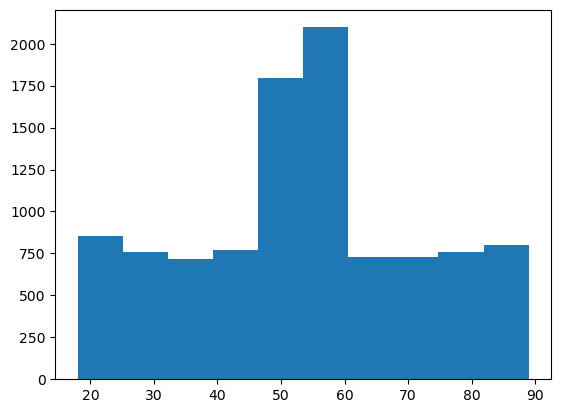

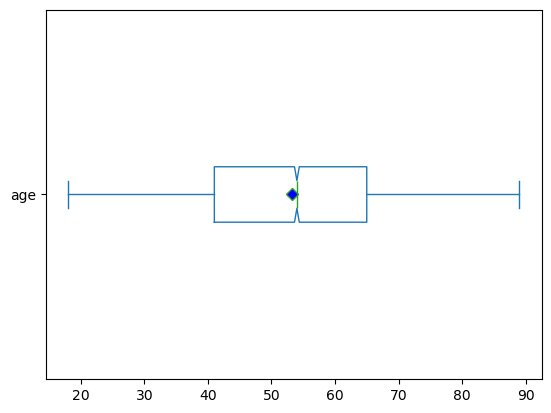

count    10000.00
mean        53.29
std         18.04
min         18.00
25%         41.00
50%         54.00
75%         65.00
max         89.00
Name: age, dtype: float64
-------------------------------
The mode is: 54.0
____________________________________________
The Information Below is For: children


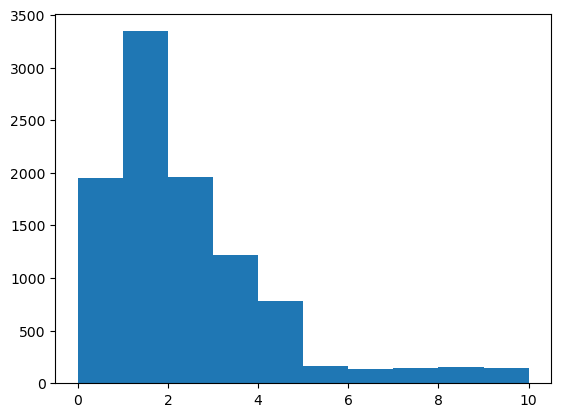

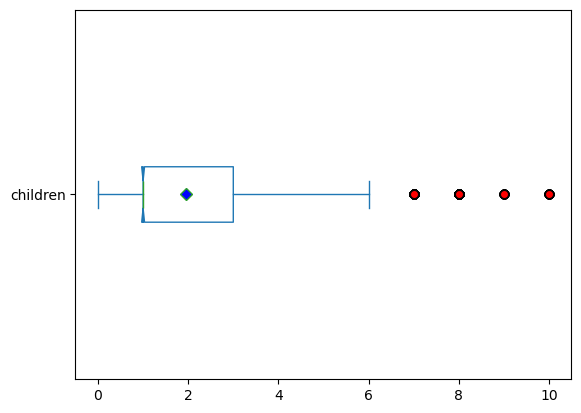

count    10000.000
mean         1.947
std          1.911
min          0.000
25%          1.000
50%          1.000
75%          3.000
max         10.000
Name: children, dtype: float64
-------------------------------
The mode is: 1.0
____________________________________________
The Information Below is For: income


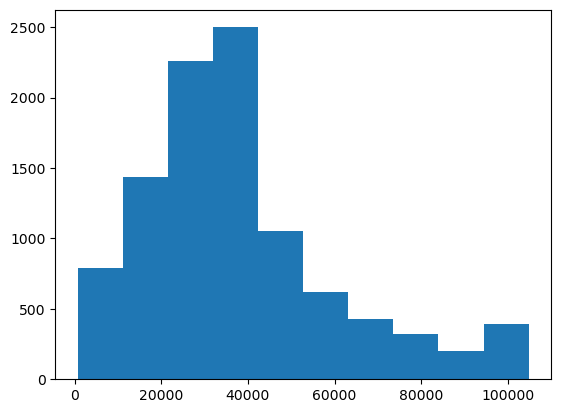

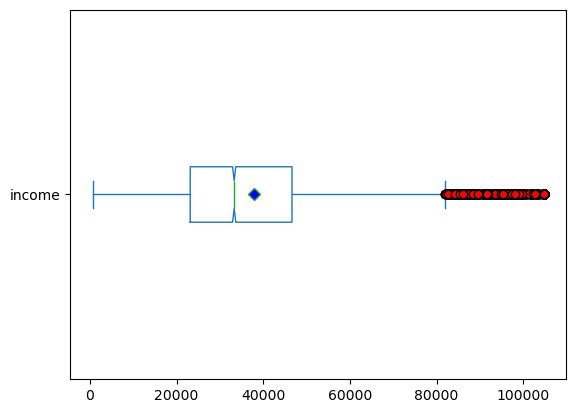

count     10000.000
mean      37826.913
std       22694.816
min         740.660
25%       23163.538
50%       33304.890
75%       46638.982
max      104752.704
Name: income, dtype: float64
-------------------------------
The mode is: 104752.70375000002
____________________________________________
The Information Below is For: monthly_charge


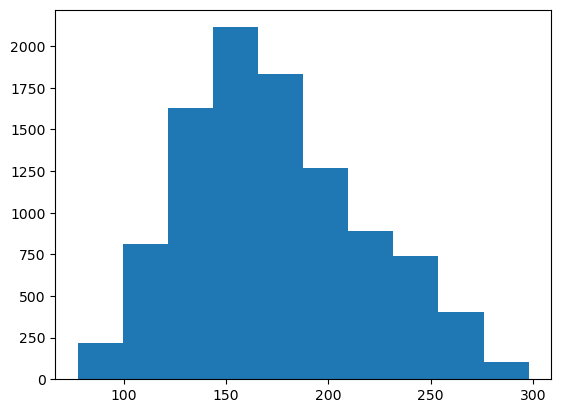

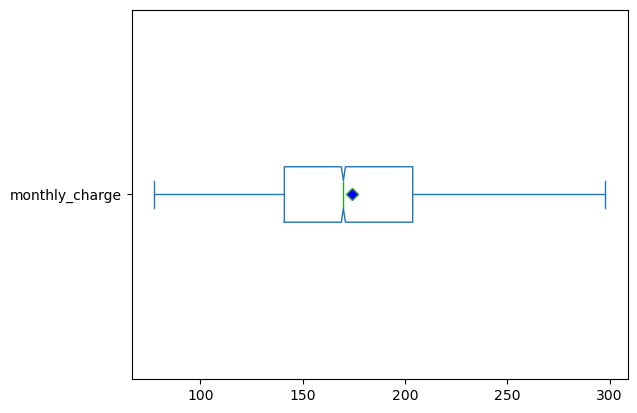

count    10000.000
mean       174.073
std         43.324
min         77.505
25%        141.071
50%        169.915
75%        203.777
max        297.837
Name: monthly_charge, dtype: float64
-------------------------------
The mode is: 297.8369855125
____________________________________________
The Information Below is For: bandwidth_gb_year


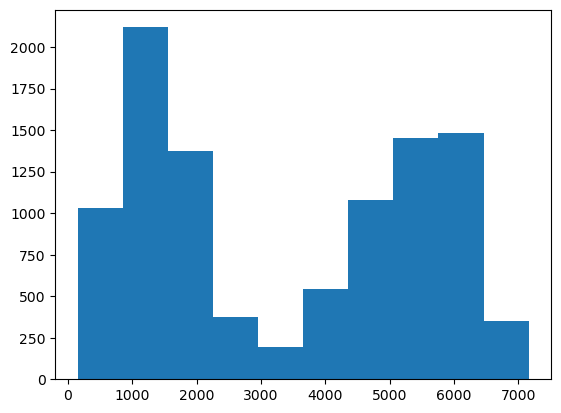

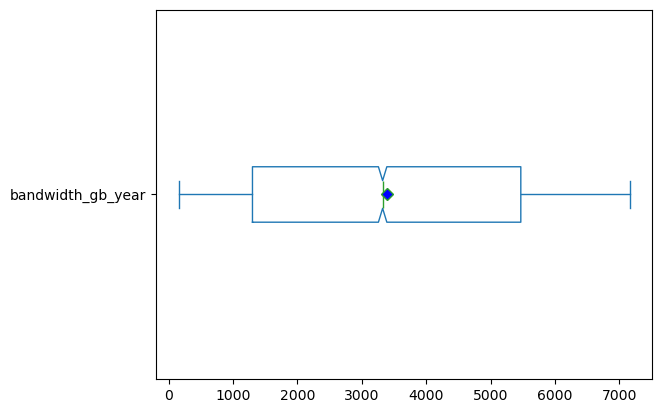

count    10000.000
mean      3387.142
std       2110.914
min        155.507
25%       1302.185
50%       3323.735
75%       5470.032
max       7158.982
Name: bandwidth_gb_year, dtype: float64
-------------------------------
The mode is: 4159.306
____________________________________________


In [16]:

univar(churn,'age')
univar(churn,'children')
univar(churn,'income')
univar(churn,'monthly_charge')
univar(churn,'bandwidth_gb_year')